### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import os
import torch

### Read dataset labels

In [2]:
# Set the folder path
folder_path = 'fruits-detection/train/labels/'

# Class names
class_names = {0: 'apple', 1: 'banana', 2: 'grape', 3: 'orange', 4: 'pineapple', 5: 'watermelon'}

# Create an empty list to store DataFrames
dfs = []

# Iterate through the files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".txt"):
        file_path = os.path.join(folder_path, file)
        # Read the text file into a DataFrame
        df = pd.read_csv(file_path, delimiter=" ", names=["label", "coordinate_1", "coordinate_2", "coordinate_3", "coordinate_4"])  # Adjust column names as needed
        # Add file name without extension
        df["filename"] = os.path.splitext(file)[0] + '.jpg'
        # Map numeric labels to class names
        df["class_name"] = df["label"].map(class_names)
        dfs.append(df)

# Concatenate all DataFrames into one
final_df = pd.concat(dfs, ignore_index=True)

# Display settings
df.style.set_properties(**{'text-align': 'center'})
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# Display the concatenated DataFrame
print(final_df.head())

   label  coordinate_1  coordinate_2  coordinate_3  coordinate_4                                                      filename class_name
0      3      0.015625      0.525781      0.030859      0.079687  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange
1      3      0.026562      0.782031      0.053125      0.104688  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange
2      3      0.029687      0.953906      0.059375      0.089063  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange
3      3      0.035937      0.603125      0.071094      0.075781  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange
4      3      0.021875      0.679688      0.037891      0.072656  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange


### Check images

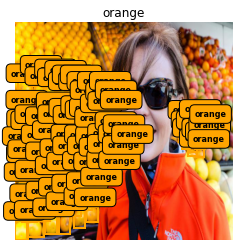

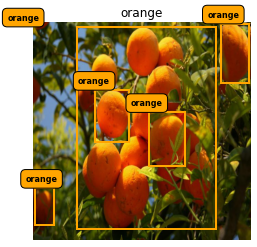

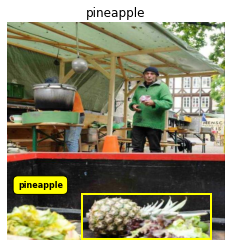

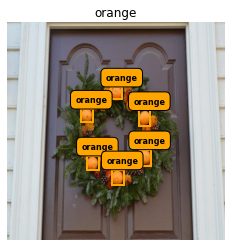

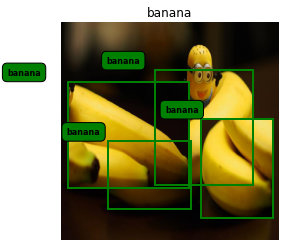

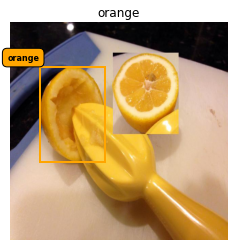

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Set the folder path
folder_path = 'fruits-detection/train/images/'

# Group the DataFrame by filename and iterate through each group
for _, group in final_df[:100].groupby('filename'):
    # Load the image
    image_path = os.path.join(folder_path, group.iloc[0]['filename'])  # Use the filename of the first row in the group
    try:
        image = Image.open(image_path)
    except Exception as e:
        print(f"Error loading image {group.iloc[0]['filename']}: {e}")
        continue
    
    # Create a subplot
    plt.imshow(image)
    plt.axis('off')
    
    # Define colors for different labels
    label_colors = {'apple': 'red', 'banana': 'green', 'grape': 'white', 'orange': 'orange', 'pineapple': 'yellow', 'watermelon': 'pink'}
    unique_labels = set(group['class_name'])
    label_y_offset = 0  # Initial y offset for labels
    
    # Iterate through each unique label in the group and plot the bounding box
    for label in unique_labels:
        color = label_colors[label]
        bbox_found = False
        
        # Iterate through each row in the group and find the last bounding box for the current label
        for _, row in group.iterrows():
            if row['class_name'] == label:
                bbox_found = True
                width, height = image.size
                x_center, y_center, bbox_width, bbox_height = row[['coordinate_1', 'coordinate_2', 'coordinate_3', 'coordinate_4']]
                x1 = (x_center - bbox_width / 2) * width
                y1 = (y_center - bbox_height / 2) * height
                rect = patches.Rectangle((x1, y1), bbox_width * width, bbox_height * height, linewidth=2, edgecolor=color, facecolor='none')
                plt.gca().add_patch(rect)
                
                # Calculate the position of the label outside the bounding box
                text_x = x1 - bbox_width * width / 2  # Adjusted x position
                text_y = y1 - 20 - label_y_offset  # Adjusted y position
                bbox_props = dict(boxstyle="round,pad=0.6", fc=color, ec="black", lw=1)  # Background properties
                plt.text(text_x, text_y, label, fontsize=8, color='black', weight='bold', bbox=bbox_props)
        
        # Update the y offset for labels
        if bbox_found:
            label_y_offset += 20
    
    # Add title
    plt.title(', '.join(unique_labels))  # Use the unique labels in the group as the title
    plt.show()

Since we are going to identify what's in the image (classification task) we can remove all the coordinates followed by the duplicate rows

In [4]:
final_df = final_df.loc[:, ~final_df.columns.str.startswith('coordinate_')]
final_df.drop_duplicates(inplace=True)
print(final_df.head(10))

     label                                                      filename class_name
0        3  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange
83       4  16d6f1e3fd4443ac_jpg.rf.efc9727f1c46b50814e57b4531f345aa.jpg  pineapple
84       3  17cc9895a4c6b32b_jpg.rf.1c424669691a15f97b943fdc23d9cfaa.jpg     orange
90       1  87eea574340d5d48_jpg.rf.bed151caef6965fe2806b2309278783e.jpg     banana
94       3  093d9c02650b69bc_jpg.rf.1b57af4d3140051819d5c53e73b3d9b4.jpg     orange
99       3  b8208415b699481c_jpg.rf.6387b8a7eaf115cc25ceb515d6a974b8.jpg     orange
101      2  4bac3cc0022db7d3_jpg.rf.9fc195a6198eca41b7d5403e72f0c227.jpg      grape
102      0  a9066c613e840878_jpg.rf.1cd83f5a7902932675e3278c51bf2c03.jpg      apple
103      2  41a81ccea2949e58_jpg.rf.cc8ff4dfcd21d95f09a7c9b96cd78b06.jpg      grape
104      3  53b4f49b09747d35_jpg.rf.839aa688922bf79e7511c45da2fea2f4.jpg     orange


In [5]:
len(final_df)

7387

In [6]:
len(final_df['filename'].unique())

7108

### Transform labels to tensor
Get labels:
In this step we are going to transform each label into a multi-label one hot encoding tensor.
Since we are going to identify what's in the image (classification task) we can remove all the coordinates followed by the duplicate rows.
We are going to prepare this data to use it in a multi-label classification task. The goal is to predict multiple labels for each instance (image, in this case). This is because when inspecting the dataset we can see that each image might have more than one fruit. We are going to transform each label in a binary variable, indicating whether the label is present or not.

In [162]:
# Convert class names to a dictionary mapping
class_names = {'apple': 0, 'banana': 1, 'grape': 2, 'orange': 3, 'pineapple': 4, 'watermelon': 5}

# Initialize an empty list to store multi-label encoded labels
multi_label_labels_dict = {}

# Iterate over the rows of the DataFrame
for _, row in final_df.iterrows():
    filename = row['filename']
    labels = set(final_df[final_df['filename'] == filename]['class_name'].tolist()) # If there are multiple fruits in an image
    
    # Initialize an array of zeros for multi-label encoding
    multi_label_labels = [0] * len(class_names)
    
    # Set the corresponding indices to 1 for each label
    for label in labels:
        label_index = class_names.get(label)
        multi_label_labels[label_index] = 1

    # Append the multi-label encoded labels to the dictionary
    multi_label_labels_dict[filename] = [multi_label_labels]


# Convert the dictionary of lists to a list of arrays
multi_label_labels_list = [torch.tensor(labels) for labels in multi_label_labels_dict.values()]

# Stack the padded tensors to create a single tensor
multi_label_labels_tensor = torch.stack(multi_label_labels_list)

# Check shape and some of the tensors
print(multi_label_labels_tensor.shape)
print(multi_label_labels_tensor[:5])

# Print corresponding filenames
print(final_df.head())

torch.Size([7108, 1, 6])
tensor([[[0, 0, 0, 1, 0, 0]],

        [[0, 0, 0, 0, 1, 0]],

        [[0, 0, 0, 1, 0, 0]],

        [[0, 1, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0]]])
    label                                                      filename class_name
0       3  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange
83      4  16d6f1e3fd4443ac_jpg.rf.efc9727f1c46b50814e57b4531f345aa.jpg  pineapple
84      3  17cc9895a4c6b32b_jpg.rf.1c424669691a15f97b943fdc23d9cfaa.jpg     orange
90      1  87eea574340d5d48_jpg.rf.bed151caef6965fe2806b2309278783e.jpg     banana
94      3  093d9c02650b69bc_jpg.rf.1b57af4d3140051819d5c53e73b3d9b4.jpg     orange


#### Find which tensors have more than one label

In [163]:
# Calculate the sum along the second axis
label_sums = torch.sum(multi_label_labels_tensor, dim=2)
indices_more_than_one_label = torch.nonzero(label_sums > 1, as_tuple=False)

In [164]:
label_sums = label_sums.flatten().tolist()

In [165]:
# Find indices where sum is greater than 1
indices = []
for index, value in enumerate(label_sums):
    if value > 1:
        indices.append(index)
print("Indices with more than one label:")
print(indices)

Indices with more than one label:
[22, 35, 45, 80, 175, 195, 204, 276, 328, 329, 342, 354, 365, 389, 423, 429, 441, 443, 502, 509, 512, 513, 514, 538, 576, 712, 745, 783, 785, 795, 812, 824, 861, 885, 910, 926, 935, 940, 949, 990, 1001, 1048, 1066, 1147, 1155, 1165, 1174, 1183, 1187, 1229, 1245, 1259, 1268, 1291, 1304, 1325, 1333, 1343, 1375, 1455, 1481, 1496, 1534, 1557, 1612, 1655, 1661, 1668, 1674, 1716, 1793, 1804, 1807, 1812, 1813, 1819, 1839, 1853, 1895, 1932, 1950, 1994, 2033, 2111, 2124, 2155, 2187, 2242, 2266, 2321, 2356, 2360, 2441, 2443, 2468, 2547, 2554, 2593, 2600, 2635, 2644, 2656, 2672, 2689, 2690, 2729, 2745, 2818, 2850, 2892, 2900, 2944, 2957, 2985, 2986, 3016, 3047, 3065, 3094, 3120, 3142, 3175, 3176, 3270, 3379, 3422, 3459, 3463, 3471, 3493, 3511, 3521, 3527, 3565, 3576, 3603, 3610, 3614, 3659, 3686, 3830, 3861, 3914, 3998, 4045, 4090, 4109, 4123, 4142, 4154, 4176, 4203, 4210, 4229, 4233, 4272, 4273, 4286, 4343, 4347, 4348, 4375, 4455, 4477, 4510, 4531, 4536, 4601, 4

In [169]:
print("Tensors with more than one label:")
for index in indices_more_than_one_label.flatten():
    print(multi_label_labels_tensor[index])

Tensors with more than one label:
tensor([[0, 1, 0, 0, 1, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[1, 0, 0, 0, 0, 1]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[0, 0, 0, 0, 1, 1]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[1, 0, 0, 1, 0, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[1, 1, 0, 0, 0, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[0, 0, 0, 1, 0, 1]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[1, 1, 1, 0, 0, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[1, 0, 0, 1, 0, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[1, 0, 0, 1, 0, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[1, 1, 0, 0, 0, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[1, 0, 1, 0, 0, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[0, 1, 0, 0, 1, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[0, 1, 1, 0, 0, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[0, 1, 1, 0, 0, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[1, 1, 1, 0, 0, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[0, 1, 0, 1, 0, 0]])
tensor([[0, 0, 0, 1, 0, 0]])
tensor([[0, 0, 0, 1, 0, 1]])
tensor([[

#### Read images

In [7]:
image_names = final_df['filename'].tolist()
image_names[:5]

['000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg',
 '16d6f1e3fd4443ac_jpg.rf.efc9727f1c46b50814e57b4531f345aa.jpg',
 '17cc9895a4c6b32b_jpg.rf.1c424669691a15f97b943fdc23d9cfaa.jpg',
 '87eea574340d5d48_jpg.rf.bed151caef6965fe2806b2309278783e.jpg',
 '093d9c02650b69bc_jpg.rf.1b57af4d3140051819d5c53e73b3d9b4.jpg']

In [8]:
# Extract each image file by iterating through this list of files
images = []
root = 'fruits-detection/train/images/'

# Iterate through each image file name
for img_name in tqdm(image_names):
    # Construct the complete path of each image file
    image_path = os.path.join(root, img_name)
    
    # Open each image file using PIL (Python Imaging Library) and convert it into a numpy array
    image = np.asarray(Image.open(image_path), dtype='uint8')
    
    # Append the numpy array representation of the image to the 'images' list
    images.append(image)

# Convert the list of images into a numpy array
images = np.array(images)

# Find unique images in the array, removing duplicates
unique_images = np.unique(images, axis=0)

  0%|          | 0/7387 [00:00<?, ?it/s]

In [9]:
np.array(image).shape

(640, 640, 3)

In [10]:
images.shape

(7387, 640, 640, 3)

In [11]:
images

array([[[[255, 177,   0],
         [255, 176,   0],
         [255, 175,   0],
         ...,
         [123, 145, 143],
         [123, 145, 143],
         [123, 145, 143]],

        [[255, 171,   0],
         [255, 170,   0],
         [255, 169,   0],
         ...,
         [119, 141, 139],
         [123, 145, 143],
         [125, 147, 145]],

        [[255, 163,   0],
         [254, 161,   0],
         [252, 161,   0],
         ...,
         [112, 132, 131],
         [117, 137, 136],
         [121, 141, 140]],

        ...,

        [[253, 212,   0],
         [253, 212,   0],
         [253, 212,   0],
         ...,
         [255, 245, 183],
         [255, 249, 187],
         [254, 248, 186]],

        [[252, 211,   0],
         [252, 211,   0],
         [252, 211,   0],
         ...,
         [255, 245, 183],
         [255, 248, 185],
         [254, 248, 186]],

        [[252, 212,   0],
         [251, 210,   0],
         [251, 210,   0],
         ...,
         [254, 244, 182],
        

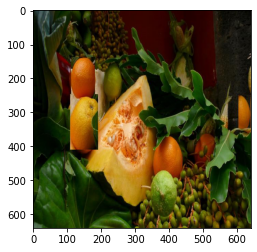

In [12]:
plt.imshow(image)

In [13]:
unique_images = np.unique(images, axis=0)

In [14]:
unique_images

array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
        

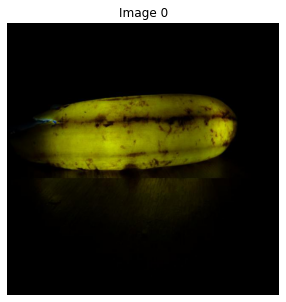

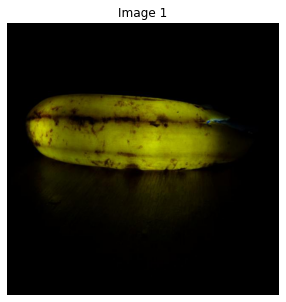

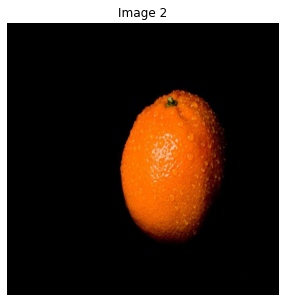

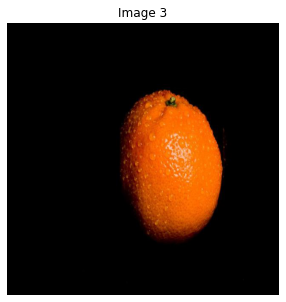

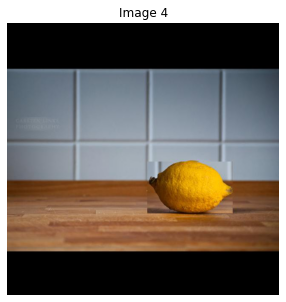

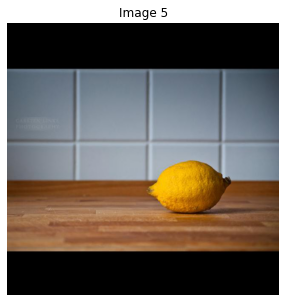

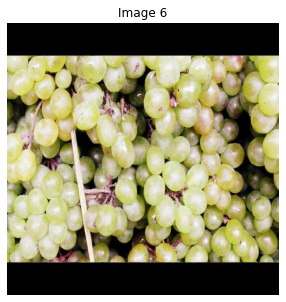

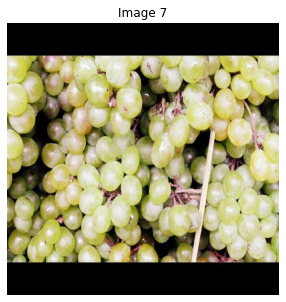

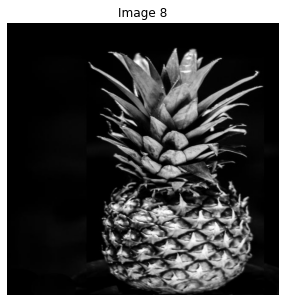

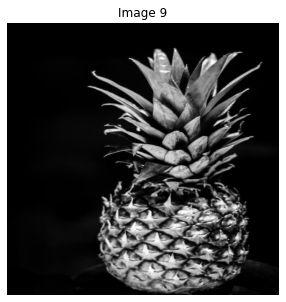

In [15]:
import matplotlib.pyplot as plt

# Plot each image separately
for i in range(10):  # Plotting images from index 5 to 15
    plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
    plt.imshow(unique_images[i])
    plt.axis('off')
    plt.title(f'Image {i}')  # Set title with image index
    plt.show()

### Labels statistics

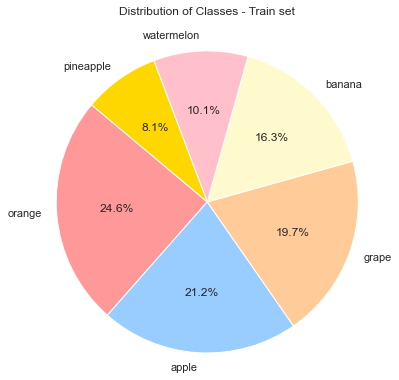

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Count the occurrences of each class
class_counts = final_df['class_name'].value_counts()

# Define custom color palette
custom_palette = ['#FF9999', '#99CCFF', '#FFCC99', '#FFFACD', '#FFC0CB', '#FFD700']

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Distribution of Classes - Train set', pad=20)  # Adjusting title spacing
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.gca().set_facecolor('white')  # Set white background

# Adjust spacing between title and plot
plt.subplots_adjust(top=0.9)

plt.show()

In [17]:
class_counts

orange        1818
apple         1564
grape         1453
banana        1205
watermelon     746
pineapple      601
Name: class_name, dtype: int64

#### Checking the proportion for the test and validation sets

In [18]:
# Set the folder path
folder_path = 'fruits-detection/test/labels/'

# Class names
class_names = {0: 'apple', 1: 'banana', 2: 'grape', 3: 'orange', 4: 'pineapple', 5: 'watermelon'}

# Create an empty list to store DataFrames
dfs = []

# Iterate through the files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".txt"):
        file_path = os.path.join(folder_path, file)
        # Read the text file into a DataFrame
        df = pd.read_csv(file_path, delimiter=" ", names=["label", "coordinate_1", "coordinate_2", "coordinate_3", "coordinate_4"])  # Adjust column names as needed
        # Add file name without extension
        df["filename"] = os.path.splitext(file)[0] + '.jpg'
        # Map numeric labels to class names
        df["class_name"] = df["label"].map(class_names)
        dfs.append(df)

# Concatenate all DataFrames into one
final_df_test = pd.concat(dfs, ignore_index=True)

# Display settings
df.style.set_properties(**{'text-align': 'center'})
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# Display the concatenated DataFrame
print(final_df_test.head())

   label  coordinate_1  coordinate_2  coordinate_3  coordinate_4                                                      filename class_name
0      2      0.266406      0.409375      0.267188      0.221094  49a87bf5fcf6153a_jpg.rf.b5e538be37e2c0a593289022673b9685.jpg      grape
1      2      0.406250      0.521094      0.050000      0.055469  49a87bf5fcf6153a_jpg.rf.b5e538be37e2c0a593289022673b9685.jpg      grape
2      2      0.596094      0.697656      0.314844      0.435156  49a87bf5fcf6153a_jpg.rf.b5e538be37e2c0a593289022673b9685.jpg      grape
3      2      0.633594      0.295312      0.335156      0.335938  49a87bf5fcf6153a_jpg.rf.b5e538be37e2c0a593289022673b9685.jpg      grape
4      2      0.689063      0.542969      0.064062      0.085156  49a87bf5fcf6153a_jpg.rf.b5e538be37e2c0a593289022673b9685.jpg      grape


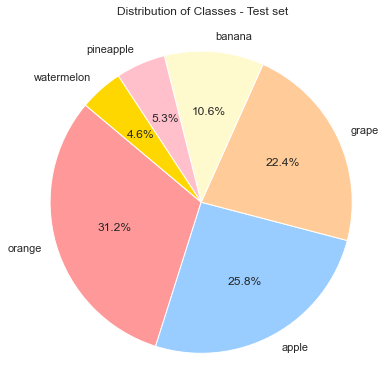

In [19]:
# Set seaborn style
sns.set(style="whitegrid")

# Count the occurrences of each class
class_counts_test = final_df_test['class_name'].value_counts()

# Define custom color palette
custom_palette = ['#FF9999', '#99CCFF', '#FFCC99', '#FFFACD', '#FFC0CB', '#FFD700']

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts_test, labels=class_counts_test.index, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Distribution of Classes - Test set', pad=20)  # Adjusting title spacing
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.gca().set_facecolor('white')  # Set white background

# Adjust spacing between title and plot
plt.subplots_adjust(top=0.9)

plt.show()

In [20]:
# Set the folder path
folder_path = 'fruits-detection/valid/labels/'

# Class names
class_names = {0: 'apple', 1: 'banana', 2: 'grape', 3: 'orange', 4: 'pineapple', 5: 'watermelon'}

# Create an empty list to store DataFrames
dfs = []

# Iterate through the files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".txt"):
        file_path = os.path.join(folder_path, file)
        # Read the text file into a DataFrame
        df = pd.read_csv(file_path, delimiter=" ", names=["label", "coordinate_1", "coordinate_2", "coordinate_3", "coordinate_4"])  # Adjust column names as needed
        # Add file name without extension
        df["filename"] = os.path.splitext(file)[0] + '.jpg'
        # Map numeric labels to class names
        df["class_name"] = df["label"].map(class_names)
        dfs.append(df)

# Concatenate all DataFrames into one
final_df_val = pd.concat(dfs, ignore_index=True)

# Display settings
df.style.set_properties(**{'text-align': 'center'})
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# Display the concatenated DataFrame
print(final_df_val.head())

   label  coordinate_1  coordinate_2  coordinate_3  coordinate_4                                                      filename class_name
0      3      0.753906      0.795312      0.232031      0.257031  6e493cf6c5db3db0_jpg.rf.d5d316ec2e29f2e331d7293bcb2ad2cb.jpg     orange
1      2      0.029687      0.710938      0.057813      0.099219  b22497d1ac4ece41_jpg.rf.28e2703d116a363e786ddde36272439c.jpg      grape
2      2      0.021094      0.724219      0.014063      0.029687  b22497d1ac4ece41_jpg.rf.28e2703d116a363e786ddde36272439c.jpg      grape
3      2      0.028906      0.678906      0.009375      0.020313  b22497d1ac4ece41_jpg.rf.28e2703d116a363e786ddde36272439c.jpg      grape
4      2      0.126562      0.764844      0.185938      0.331250  b22497d1ac4ece41_jpg.rf.28e2703d116a363e786ddde36272439c.jpg      grape


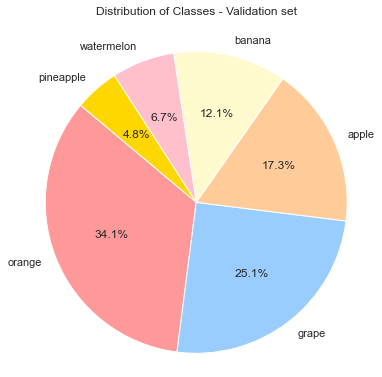

In [21]:
# Set seaborn style
sns.set(style="whitegrid")

# Count the occurrences of each class
class_counts_val = final_df_val['class_name'].value_counts()

# Define custom color palette
custom_palette = ['#FF9999', '#99CCFF', '#FFCC99', '#FFFACD', '#FFC0CB', '#FFD700']

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts_val, labels=class_counts_val.index, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Distribution of Classes - Validation set', pad=20)  # Adjusting title spacing
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.gca().set_facecolor('white')  # Set white background

# Adjust spacing between title and plot
plt.subplots_adjust(top=0.9)

plt.show()

We can see a very umbalanced dataset - we'll need to address this when loading the data into the loader